In [94]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [95]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *

In [96]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [97]:
# Load data from the CSV file
data = pd.read_csv('historical_data.csv')  

# Convert 'DATETIME' column to datetime format
data['DATETIME'] = pd.to_datetime(data['DATETIME'])

# Set 'DATETIME' column as the index
data.set_index('DATETIME', inplace=True)

In [98]:
display(data.head())

,RR,SPO2,MAP,SBP,DBP,HR,PP,CO
DATETIME,,,,,,,,
2020-10-18 15:24:00,35.0,99.9,0.0,0.0,0.0,106.9,0.0,0.00
2020-10-18 15:25:00,36.4,100.0,87.0,98.9,63.1,107.3,35.8,3841.34
2020-10-18 15:26:00,35.2,100.0,75.2,97.9,63.0,107.5,34.9,3751.75
2020-10-18 15:27:00,34.0,100.0,74.8,97.2,62.5,107.0,34.7,3712.90
2020-10-18 15:28:00,34.9,100.0,74.0,96.0,62.0,107.0,34.0,3638.00


In [99]:
# Select both SBP and DBP columns
bp_df = pd.DataFrame({'SBP': data['SBP'], 'DBP': data['DBP']})

# Drop rows where 'SBP' or 'DBP' is equal to 0
bp_df = bp_df[(bp_df['SBP'] != 0) & (bp_df['DBP'] != 0)]

In [100]:
display(bp_df)

,SBP,DBP
DATETIME,,
2020-10-18 15:25:00,98.9,63.1
2020-10-18 15:26:00,97.9,63.0
2020-10-18 15:27:00,97.2,62.5
2020-10-18 15:28:00,96.0,62.0
2020-10-18 15:29:00,95.5,61.7
...,...,...
2020-10-24 21:32:00,92.0,51.2
2020-10-24 21:33:00,89.3,50.2
2020-10-24 21:34:00,91.2,50.6


In [101]:
# sbp_df['Seconds'] = sbp_df.index.map(pd.Timestamp.timestamp)
# sbp_df

In [102]:
# day = 60*60*24   # 1 day in seconds
# sbp_df['Day sin'] = np.sin(sbp_df['Seconds'] * (2* np.pi / day))
# sbp_df['Day cos'] = np.cos(sbp_df['Seconds'] * (2 * np.pi / day))
# sbp_df.head()

In [103]:
# sbp_df = sbp_df.drop('Seconds', axis=1)
# sbp_df.head()

In [104]:
train_size = int(len(bp_df) * 0.8)
test_size = len(bp_df) - train_size
train, test = bp_df.iloc[0:train_size], bp_df.iloc[train_size:len(bp_df)]
print(len(train), len(test))

7048 1763


In [105]:
def df_to_X_y2(df, window_size):
  df_as_np = df.to_numpy()
  X = [] #shape will be the number of training examples by the number of time steps times number of variables we are using
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [106]:
time_steps = 15
X_train, y_train = df_to_X_y2(train, time_steps)
X_test, y_test = df_to_X_y2(test, time_steps)

In [107]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7033, 15, 2), (7033, 2), (1748, 15, 2), (1748, 2))

In [108]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 2)).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, 2)).reshape(X_test.shape)

y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 2)).reshape(y_train.shape)
y_test_scaled = scaler.transform(y_test.reshape(-1, 2)).reshape(y_test.shape)

In [109]:
print(X_train_scaled.shape, y_train_scaled.shape)

(7033, 15, 2) (7033, 2)


In [110]:
model = keras.Sequential()
model.add(LSTM(64, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model.add(Dense(2))  # Output layer with 2 neurons for SBP and DBP
model.compile(loss='mean_squared_error', optimizer=Adam(0.0001))

In [111]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                17152     
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 17282 (67.51 KB)
Trainable params: 17282 (67.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
history = model.fit(
    X_train_scaled, y_train_scaled,
    epochs=10,
    batch_size=16,
    validation_split=0.1,
    verbose=1,
    shuffle=False
)

In [113]:
# Predict on the scaled test set
y_pred_scaled = model.predict(X_test_scaled)

55/55 [==============================] - 0s 3ms/step


In [114]:
# Inverse transform the predictions and actual values
y_pred = scaler.inverse_transform(y_pred_scaled.reshape(-1, 2))
y_test_inverse = scaler.inverse_transform(y_test_scaled.reshape(-1, 2))

# Calculate performance metrics on the original scale
mse = mean_squared_error(y_test_inverse, y_pred)
mae = mean_absolute_error(y_test_inverse, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')

Mean Squared Error (MSE): 12.153888955248247
Mean Absolute Error (MAE): 2.023492857847934
Root Mean Squared Error (RMSE): 3.4862428135814416


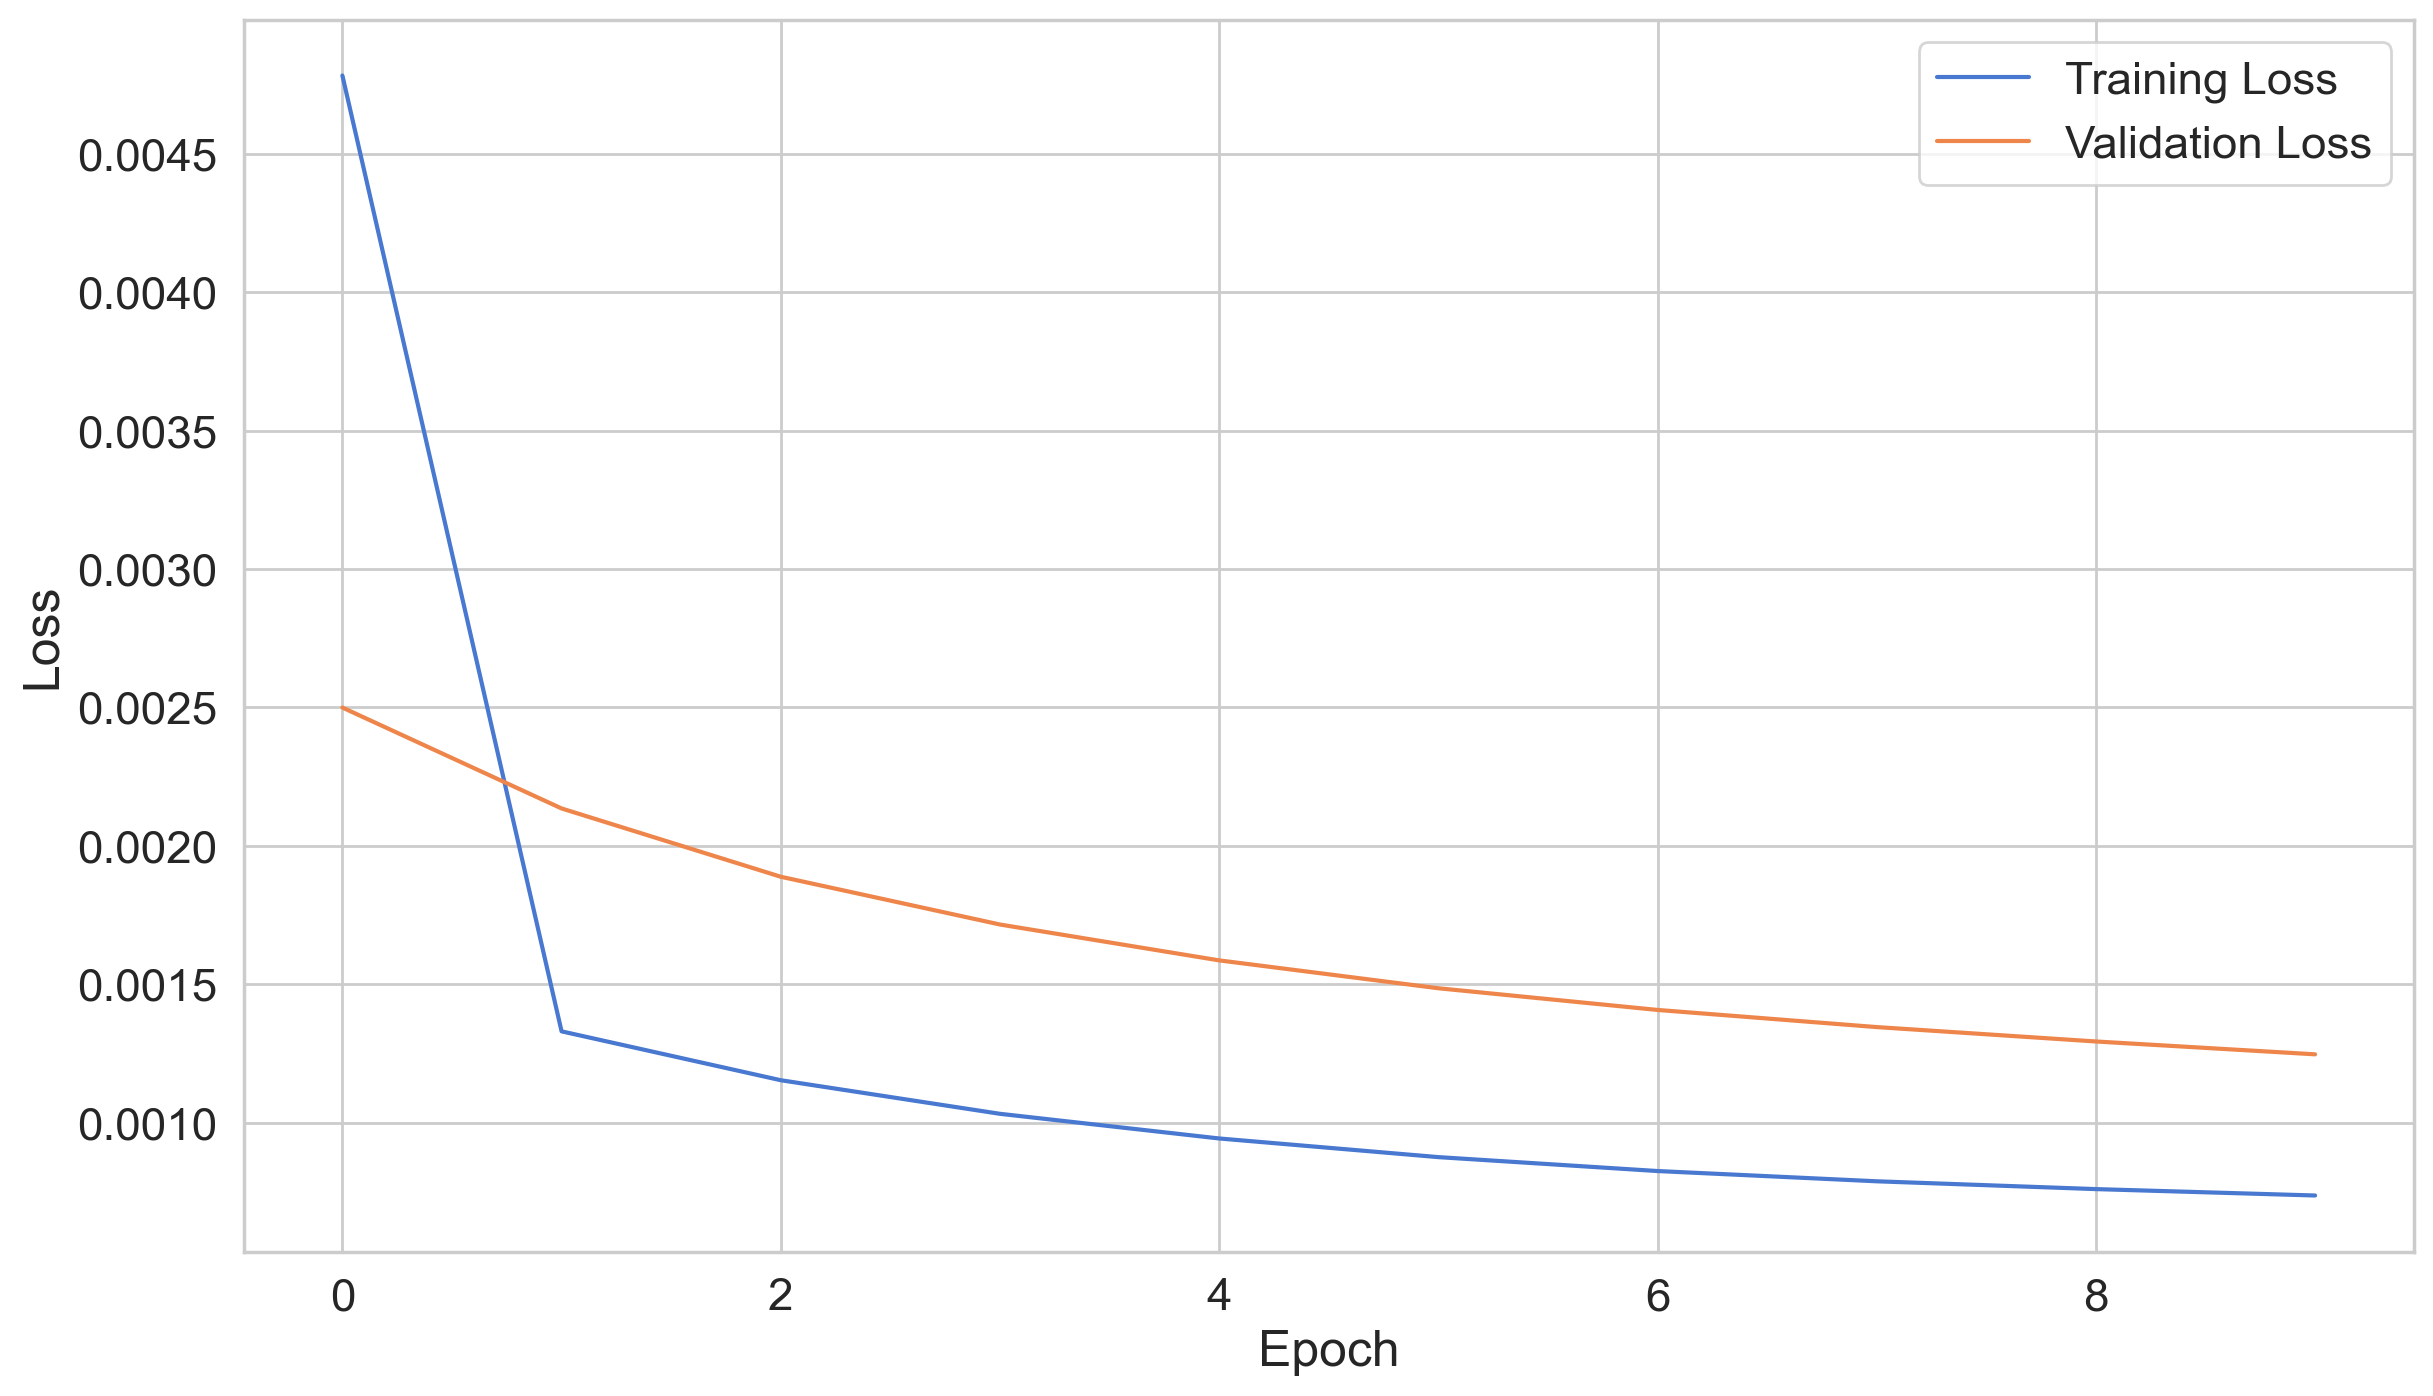

In [115]:
# Plot the training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

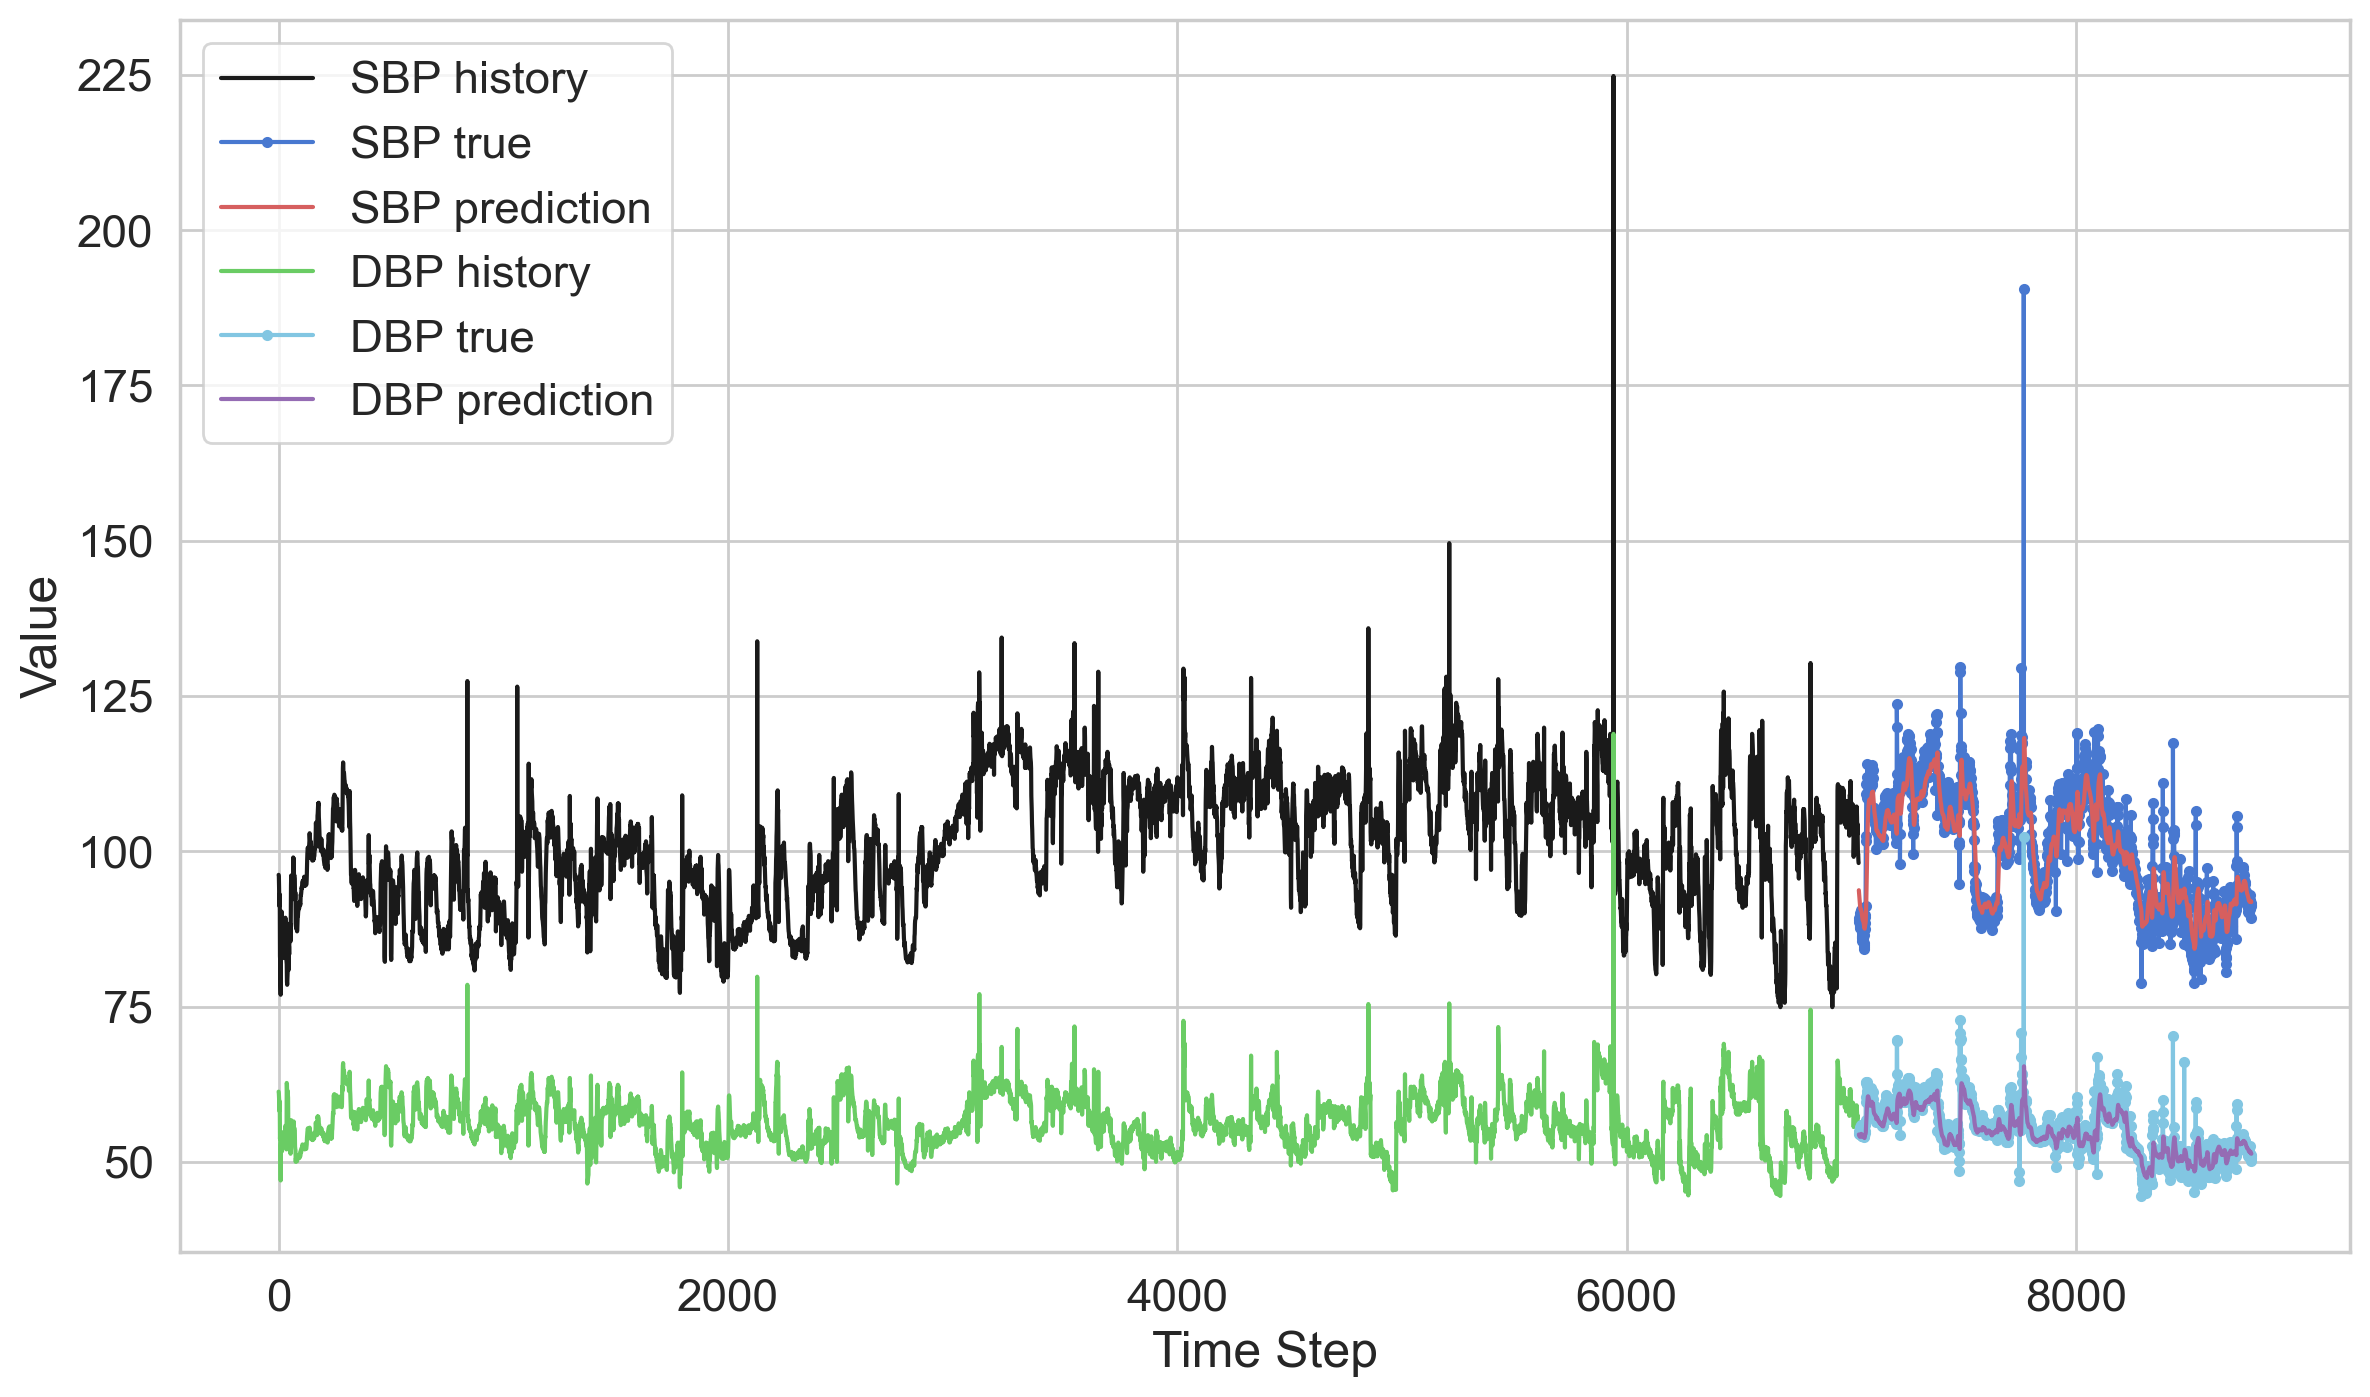

In [116]:
# Plot SBP and DBP predictions and true values
plt.plot(np.arange(0, len(y_train)), y_train[:, 0], 'k', label="SBP history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test[:, 0], marker='.', label="SBP true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred[:, 0], 'r', label="SBP prediction")

plt.plot(np.arange(0, len(y_train)), y_train[:, 1], 'g', label="DBP history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test[:, 1], 'c', marker='.', label="DBP true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred[:, 1], 'm', label="DBP prediction")

plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

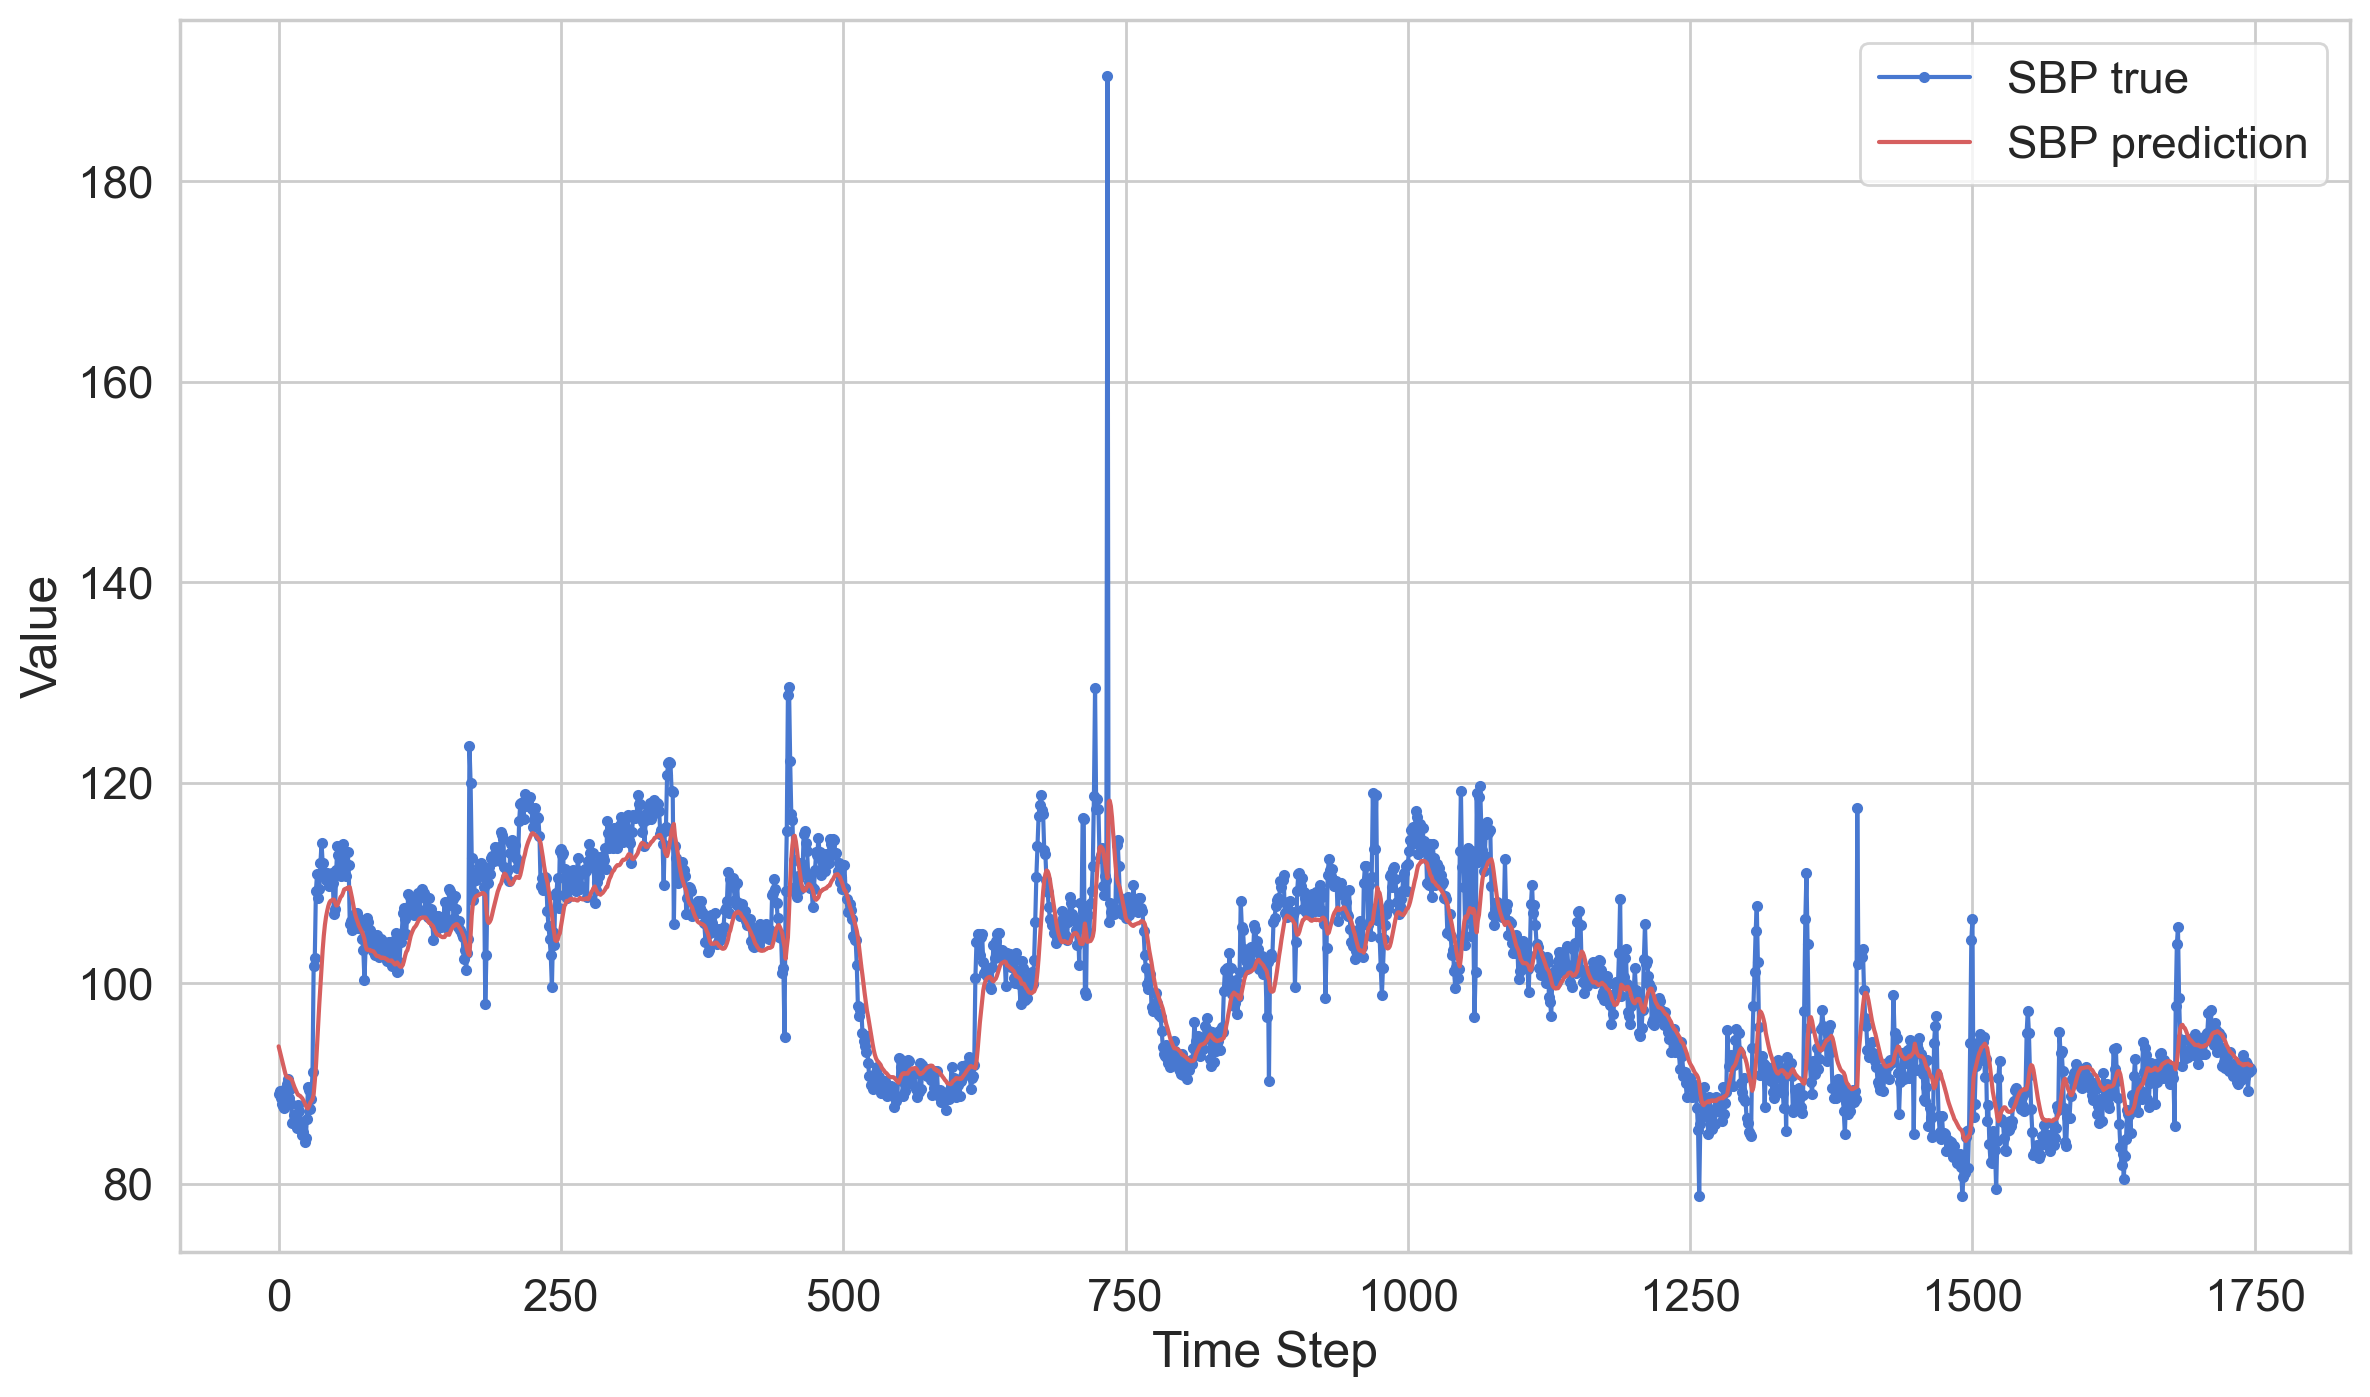

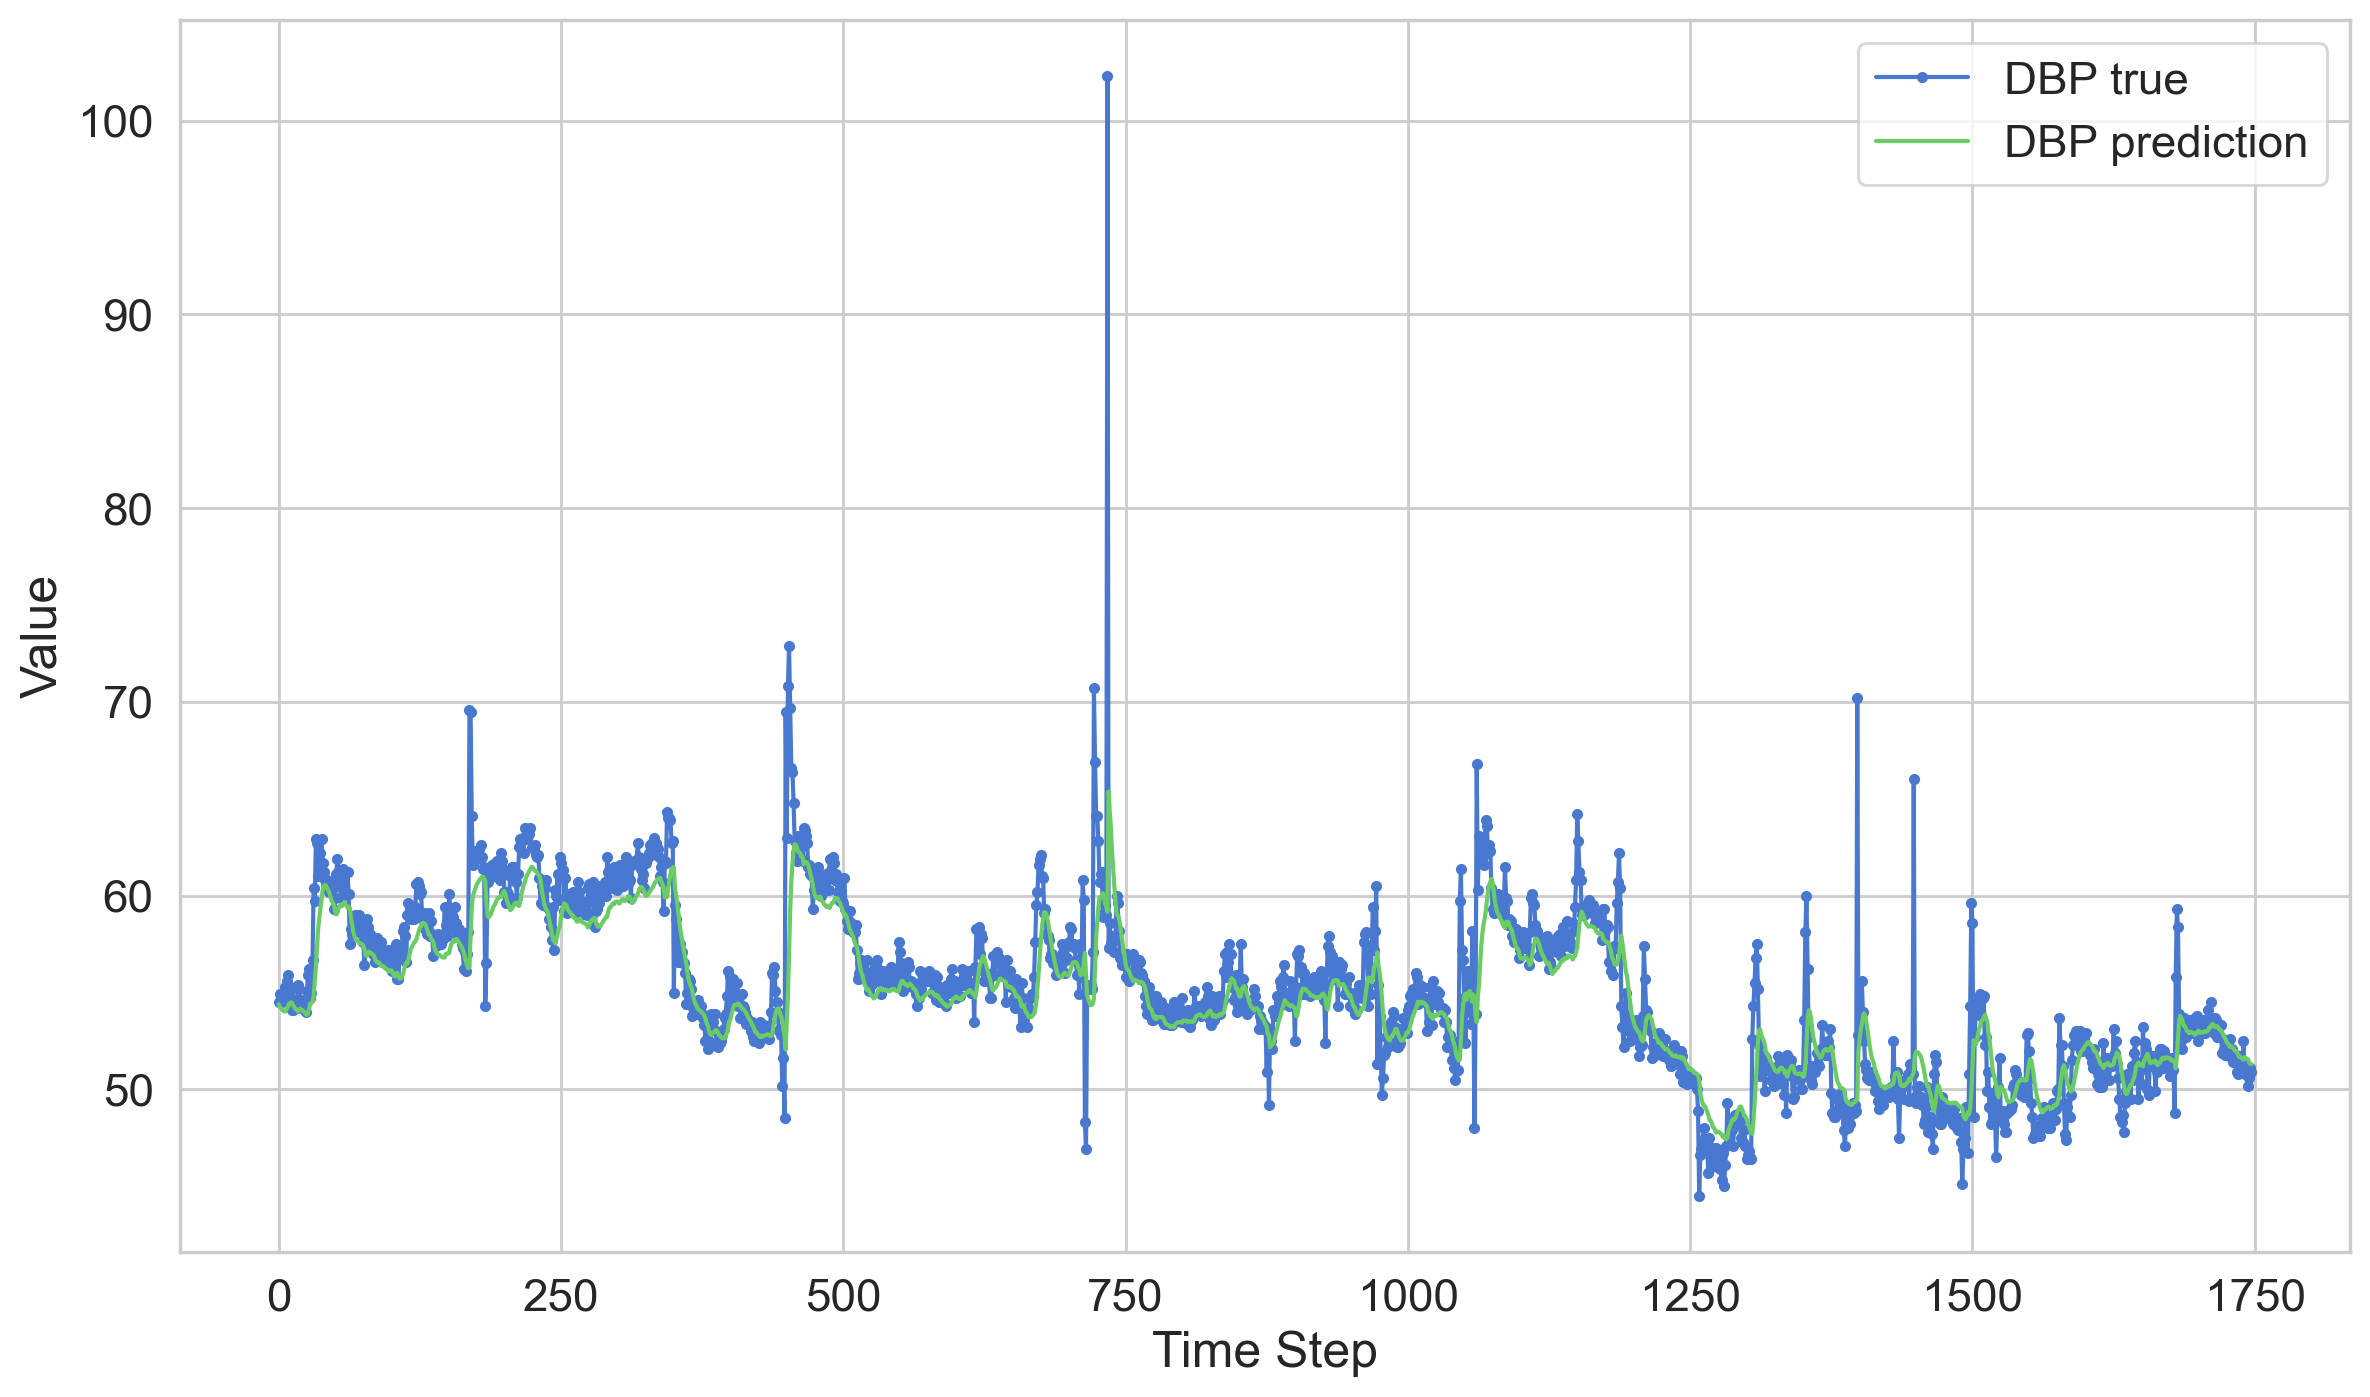

In [117]:
# Plot SBP and DBP separately for better visibility
plt.plot(y_test[:, 0], marker='.', label="SBP true")
plt.plot(y_pred[:, 0], 'r', label="SBP prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

plt.plot(y_test[:, 1], marker='.', label="DBP true")
plt.plot(y_pred[:, 1], 'g', label="DBP prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show()

In [118]:
# Inverse transform the predictions and actual values for the entire test set
y_pred_full = scaler.inverse_transform(y_pred_scaled).reshape(-1, 2)
y_test_full = scaler.inverse_transform(y_test_scaled).reshape(-1, 2)

# Create a DataFrame with SBP and DBP predictions and actual values for the test set
test_results = pd.DataFrame(data={
    'SBP Predictions': y_pred_full[:, 0],
    'DBP Predictions': y_pred_full[:, 1],
    'SBP Actuals': y_test_full[:, 0],
    'DBP Actuals': y_test_full[:, 1]
})

# Display the DataFrame
test_results.head()


,SBP Predictions,DBP Predictions,SBP Actuals,DBP Actuals
0,93.724586,54.398720,89.0,54.5
1,93.258080,54.261734,89.3,54.9
2,92.811890,54.203075,88.6,54.6
3,92.326790,54.131073,88.0,54.5
4,91.846054,54.056416,87.8,54.8


In [119]:
# Define the function to predict future values for both SBP and DBP
def predict_future(model, X, n_steps):
    predictions = []

    current_input = X[-1].reshape((1, X.shape[1], X.shape[2]))

    for _ in range(n_steps):
        # Predict the next point
        next_point_scaled = model.predict(current_input, verbose=0)
        next_point = next_point_scaled.flatten()
        predictions.append(next_point)

        # Update the input sequence for the next prediction
        current_input = np.roll(current_input, shift=-1, axis=1)
        current_input[0, -1, :] = next_point_scaled[0]

    return predictions


In [127]:
n_steps = 10

In [128]:
# Use a portion of the test set as input to the model (excluding the last 10 steps)
input_data = X_test_scaled[:-n_steps]

# Make predictions for the next 10 steps
future_predictions = predict_future(model, input_data, n_steps)

# Get the corresponding datetimes for the last 10 steps
last_n_datetimes = data.index[-n_steps:]

# Inverse transform the predictions for the next 10 steps
future_predictions_inverse = scaler.inverse_transform(np.array(future_predictions)).reshape(-1, 2)

# Inverse transform the actual values for the last 10 steps
actual_values_inverse = scaler.inverse_transform(y_test_scaled[-n_steps:, :]).reshape(-1, 2)

# Create a DataFrame for the last 10 actual and predicted points
next_results = pd.DataFrame(data={
    'Datetime': last_n_datetimes,
    'Actual SBP': actual_values_inverse[:, 0],
    'Actual DBP': actual_values_inverse[:, 1],
    'Predicted SBP': future_predictions_inverse[:, 0],
    'Predicted DBP': future_predictions_inverse[:, 1]
})

In [129]:
display(next_results)

,Datetime,Actual SBP,Actual DBP,Predicted SBP,Predicted DBP
0,2020-10-24 21:27:00,90.4,51.1,92.042435,51.693752
1,2020-10-24 21:28:00,90.8,51.3,92.049988,51.703339
2,2020-10-24 21:29:00,92.9,52.5,92.098053,51.715309
3,2020-10-24 21:30:00,90.7,50.8,92.165672,51.730400
4,2020-10-24 21:31:00,92.2,51.1,92.239868,51.744770
5,2020-10-24 21:32:00,92.0,51.2,92.326569,51.759247
6,2020-10-24 21:33:00,89.3,50.2,92.413918,51.777317
7,2020-10-24 21:34:00,91.2,50.6,92.494087,51.793438
8,2020-10-24 21:35:00,91.6,51.1,92.579834,51.812016
9,2020-10-24 21:36:00,91.4,50.9,92.671150,51.825329


In [130]:
# Calculate evaluation metrics for SBP
mae_sbp = mean_absolute_error(actual_values_inverse[:, 0], future_predictions_inverse[:, 0])
mse_sbp = mean_squared_error(actual_values_inverse[:, 0], future_predictions_inverse[:, 0])
rmse_sbp = np.sqrt(mse_sbp)

# Calculate evaluation metrics for DBP
mae_dbp = mean_absolute_error(actual_values_inverse[:, 1], future_predictions_inverse[:, 1])
mse_dbp = mean_squared_error(actual_values_inverse[:, 1], future_predictions_inverse[:, 1])
rmse_dbp = np.sqrt(mse_dbp)

# Print evaluation metrics
print('SBP Metrics:')
print(f'Mean Absolute Error (MAE): {mae_sbp}')
print(f'Mean Squared Error (MSE): {mse_sbp}')
print(f'Root Mean Squared Error (RMSE): {rmse_sbp}')

print('\nDBP Metrics:')
print(f'Mean Absolute Error (MAE): {mae_dbp}')
print(f'Mean Squared Error (MSE): {mse_dbp}')
print(f'Root Mean Squared Error (RMSE): {rmse_dbp}')


SBP Metrics:
Mean Absolute Error (MAE): 1.2185467529296887
Mean Squared Error (MSE): 2.110665372075519
Root Mean Squared Error (RMSE): 1.4528129170941173

DBP Metrics:
Mean Absolute Error (MAE): 0.8324298095703128
Mean Squared Error (MSE): 0.8000516099234807
Root Mean Squared Error (RMSE): 0.894456041358926


In [ ]:
# Plot actual and predicted values for SBP and DBP in the same plot
plt.plot(last_n_datetimes, actual_values_inverse[:, 0], label='Actual SBP', marker='o', color='blue')
plt.plot(last_n_datetimes, future_predictions_inverse[:, 0], label='Predicted SBP', marker='x', color='red')
plt.plot(last_n_datetimes, actual_values_inverse[:, 1], label='Actual DBP', marker='o', color='green')
plt.plot(last_n_datetimes, future_predictions_inverse[:, 1], label='Predicted DBP', marker='x', color='purple')

plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.legend()
plt.title('SBP and DBP Predictions vs Actuals')
plt.show()
